# DAT565 Introduction to Data Science and AI
## 2023-2024, LP2
## Assignment 4: Spam classification using Naïve Bayes
This assignment has three obligatory questions. Questions 4-5 are optional and will not be graded.

The exercise takes place in this notebook environment where you can chose to use Jupyter or Google Colabs. We recommend you use Google Colabs as it will facilitate remote group-work and makes the assignment less technical.

*Tips:*
* You can execute certain Linux shell commands by prefixing the command with a `!`.
* You can insert Markdown cells and code cells. The first you can use for documenting and explaining your results, the second you can use to write code snippets that execute the tasks required.  

In this assignment you will implement a Naïve Bayes classifier in Python that will classify emails into spam and non-spam (“ham”) classes.  Your program should be able to train on a given set of spam and “ham” datasets.

You will work with the datasets available at https://spamassassin.apache.org/old/publiccorpus/. There are three types of files in this location:
-	easy-ham: non-spam messages typically quite easy to differentiate from spam messages.
-	hard-ham: non-spam messages more difficult to differentiate
-	spam: spam messages

**Execute the cell below to download and extract the data into the environment of the notebook -- it will take a few seconds.**

If you chose to use Jupyter notebooks you will have to run the commands in the cell below on your local computer. Note that if you are using Windows, you can instead use [7zip](https://www.7-zip.org/download.html) to decompress the data (you will have to modify the cell below).

**What to submit:**
* Convert the notebook to a PDF file by compiling it, and submit the PDF file.
* Make sure all cells are executed so all your code and its results are included.
* Double-check that the PDF displays correctly before you submit it.

In [35]:
# download and extract the data
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
!wget https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2
!tar -xjf 20021010_easy_ham.tar.bz2
!tar -xjf 20021010_hard_ham.tar.bz2
!tar -xjf 20021010_spam.tar.bz2

--2023-11-28 16:32:14--  https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1677144 (1.6M) [application/x-bzip2]
Saving to: ‘20021010_easy_ham.tar.bz2.4’

20021010_easy_ham.t 100%[===================>]   1.60M  --.-KB/s    in 0.06s   

2023-11-28 16:32:14 (26.3 MB/s) - ‘20021010_easy_ham.tar.bz2.4’ saved [1677144/1677144]

--2023-11-28 16:32:15--  https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
Resolving spamassassin.apache.org (spamassassin.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to spamassassin.apache.org (spamassassin.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1021126 (997K) [application/x-bzip2]
Saving to: ‘20021010_har

The data is now in the following three folders: `easy_ham`, `hard_ham`, and `spam`. You can confirm this via the following command:

In [36]:
!ls -lah

total 19M
drwxr-xr-x 1 root root 4.0K Nov 28 16:32 .
drwxr-xr-x 1 root root 4.0K Nov 28 15:56 ..
-rw-r--r-- 1 root root 1.6M Jun 29  2004 20021010_easy_ham.tar.bz2
-rw-r--r-- 1 root root 1.6M Jun 29  2004 20021010_easy_ham.tar.bz2.1
-rw-r--r-- 1 root root 1.6M Jun 29  2004 20021010_easy_ham.tar.bz2.2
-rw-r--r-- 1 root root 1.6M Jun 29  2004 20021010_easy_ham.tar.bz2.3
-rw-r--r-- 1 root root 1.6M Jun 29  2004 20021010_easy_ham.tar.bz2.4
-rw-r--r-- 1 root root 998K Dec 16  2004 20021010_hard_ham.tar.bz2
-rw-r--r-- 1 root root 998K Dec 16  2004 20021010_hard_ham.tar.bz2.1
-rw-r--r-- 1 root root 998K Dec 16  2004 20021010_hard_ham.tar.bz2.2
-rw-r--r-- 1 root root 998K Dec 16  2004 20021010_hard_ham.tar.bz2.3
-rw-r--r-- 1 root root 998K Dec 16  2004 20021010_hard_ham.tar.bz2.4
-rw-r--r-- 1 root root 1.2M Jun 29  2004 20021010_spam.tar.bz2
-rw-r--r-- 1 root root 1.2M Jun 29  2004 20021010_spam.tar.bz2.1
-rw-r--r-- 1 root root 1.2M Jun 29  2004 20021010_spam.tar.bz2.2
-rw-r--r-- 1 root root 1

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB

### 1. Preprocessing:
Note that the email files contain a lot of extra information, besides the actual message. Ignore that for now and run on the entire text (in the optional part further down, you can experiment with filtering out the headers and footers).
1.	We don’t want to train and test on the same data (it might help to reflect on **why** ,if you don't recall). Split the spam and ham datasets into a training set and a test set. (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`). Use `easy_ham` for quesions 1 and 2.


In [38]:
# write your pre-processing code here

easy_ham = []
hard_ham = []
spam = []

for filename in os.listdir('easy_ham'):
    with open('easy_ham/' + filename, 'r', encoding='latin-1') as f:
        easy_ham.append(f.read())

for filename in os.listdir('hard_ham'):
    with open('hard_ham/' + filename, 'r', encoding='latin-1') as f:
        hard_ham.append(f.read())

for filename in os.listdir('spam'):
    with open('spam/' + filename, 'r', encoding='latin-1') as f:
        spam.append(f.read())

easy_ham = pd.DataFrame(easy_ham, columns=['text'])
easy_ham['label'] = 'easy_ham'
hard_ham = pd.DataFrame(hard_ham, columns=['text'])
hard_ham['label'] = 'hard_ham'
spam = pd.DataFrame(spam, columns=['text'])
spam['label'] = 'spam'

df = pd.concat([easy_ham, hard_ham, spam], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)

# Remove newlines, tabs, carriage returns, and punctuation to clean up the text for easier processing
df['text'] = df['text'].str.replace('\n', ' ')
df['text'] = df['text'].str.replace('\t', ' ')
df['text'] = df['text'].str.replace('\r', ' ')
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('[^\w\s]', ' ')
df['text'] = df['text'].str.replace(' +', ' ')
df['text'] = df['text'].str.strip()

easy_hamtrain = df[df['label'] == 'easy_ham'].sample(frac=0.8)
easy_hamtest = df[df['label'] == 'easy_ham'].drop(easy_hamtrain.index)
hard_hamtrain = df[df['label'] == 'hard_ham'].sample(frac=0.8)
hard_hamtest = df[df['label'] == 'hard_ham'].drop(hard_hamtrain.index)
spamtrain = df[df['label'] == 'spam'].sample(frac=0.8)
spamtest = df[df['label'] == 'spam'].drop(spamtrain.index)

easy_train = pd.concat([easy_hamtrain, spamtrain], ignore_index=True)   # Combine the training data
easy_train = easy_train.sample(frac=1).reset_index(drop=True)           # Shuffle the training data
easy_test = pd.concat([easy_hamtest, spamtest], ignore_index=True)      # Combine the testing data
easy_test = easy_test.sample(frac=1).reset_index(drop=True)             # Shuffle the testing data

hard_train = pd.concat([hard_hamtrain, spamtrain], ignore_index=True)
hard_train = hard_train.sample(frac=1).reset_index(drop=True)
hard_test = pd.concat([hard_hamtest, spamtest], ignore_index=True)
hard_test = hard_test.sample(frac=1).reset_index(drop=True)

<ipython-input-38-eaff85657731>:34: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]', ' ')
<ipython-input-38-eaff85657731>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(' +', ' ')


### 2. Write a Python program that:
1.	Uses the four datasets from Question 1 (`hamtrain`, `spamtrain`, `hamtest`, and `spamtest`).
2.	Trains a Naïve Bayes classifier (use the [scikit-learn library](https://scikit-learn.org/stable/)) on `hamtrain` and `spamtrain`, that classifies the test sets and reports True Positive and False Negative rates on the `hamtest` and `spamtest` datasets. You can use `CountVectorizer` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)) to transform the email texts into vectors. Please note that there are different types of Naïve Bayes Classifiers available in *scikit-learn* ([Documentation here](https://scikit-learn.org/stable/modules/naive_bayes.html)). Here, you will test two of these classifiers that are well suited for this problem:
- Multinomial Naive Bayes
- Bernoulli Naive Bayes.

Please inspect the documentation to ensure input to the classifiers is appropriate before you start coding. You may have to modify your input.

In [39]:
vectorizer = CountVectorizer()
vectorizer.fit(easy_train['text'])
X_train = vectorizer.transform(easy_train['text'])
X_test = vectorizer.transform(easy_test['text'])
y_train = easy_train['label']
y_test = easy_test['label']

#### 2.1 Multinomial Naive Bayes

True positive rate (recall) for easy_ham: 0.9980392156862745
False negative rate for easy_ham: 0.00196078431372549
True positive rate (recall) for spam: 0.89
False negative rate for spam: 0.11
              precision    recall  f1-score   support

    easy_ham       0.98      1.00      0.99       510
        spam       0.99      0.89      0.94       100

    accuracy                           0.98       610
   macro avg       0.98      0.94      0.96       610
weighted avg       0.98      0.98      0.98       610



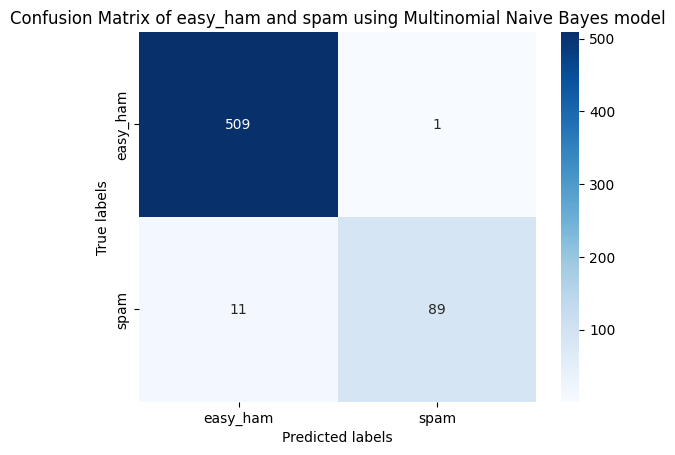

In [40]:
# Train the multinomial naive bayes model
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print true positive rate (recall), false negative rate and classification report
print('True positive rate (recall) for easy_ham: ' + str(cm[0][0] / (cm[0][0] + cm[0][1])))
print('False negative rate for easy_ham: ' + str(cm[0][1] / (cm[0][0] + cm[0][1])))
print('True positive rate (recall) for spam: ' + str(cm[1][1] / (cm[1][0] + cm[1][1])))
print('False negative rate for spam: ' + str(cm[1][0] / (cm[1][0] + cm[1][1])))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of easy_ham and spam using Multinomial Naive Bayes model')
ax.xaxis.set_ticklabels(['easy_ham', 'spam'])
ax.yaxis.set_ticklabels(['easy_ham', 'spam'])
plt.show()

#### 2.2 Bernoulli Naive Bayes

True positive rate (recall) for easy_ham: 0.9980392156862745
False negative rate for easy_ham: 0.00196078431372549
True positive rate (recall) for spam: 0.89
False negative rate for spam: 0.11
              precision    recall  f1-score   support

    easy_ham       0.92      1.00      0.96       510
        spam       0.96      0.55      0.70       100

    accuracy                           0.92       610
   macro avg       0.94      0.77      0.83       610
weighted avg       0.93      0.92      0.91       610



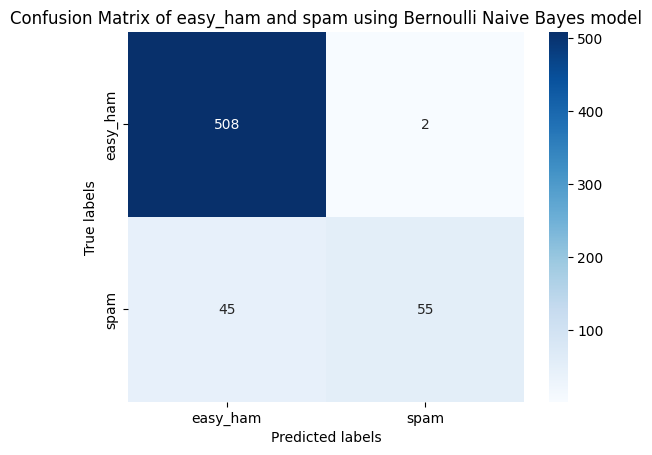

In [41]:
# Bernoulli Naive Bayes

model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print true positive rate (recall), false negative rate and classification report
print('True positive rate (recall) for easy_ham: ' + str(cm[0][0] / (cm[0][0] + cm[0][1])))
print('False negative rate for easy_ham: ' + str(cm[0][1] / (cm[0][0] + cm[0][1])))
print('True positive rate (recall) for spam: ' + str(cm[1][1] / (cm[1][0] + cm[1][1])))
print('False negative rate for spam: ' + str(cm[1][0] / (cm[1][0] + cm[1][1])))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of easy_ham and spam using Bernoulli Naive Bayes model')
ax.xaxis.set_ticklabels(['easy_ham', 'spam'])
ax.yaxis.set_ticklabels(['easy_ham', 'spam'])
plt.show()

### 3. Run on hard ham:
Run the two models from Question 2 on `spam` versus `hard-ham`, and compare to the `easy-ham` results.

Multinomial Naive Bayes - Spam vs. Hard_Ham:
              precision    recall  f1-score   support

    hard_ham       0.95      0.82      0.88        50
        spam       0.92      0.98      0.95       100

    accuracy                           0.93       150
   macro avg       0.93      0.90      0.91       150
weighted avg       0.93      0.93      0.93       150

True positive rate (recall) for hard_ham: 0.82
False negative rate for hard_ham: 0.18
True positive rate (recall) for spam: 0.98
False negative rate for spam: 0.02


Bernoulli Naive Bayes - Spam vs. Hard_Ham:
              precision    recall  f1-score   support

    hard_ham       0.97      0.64      0.77        50
        spam       0.85      0.99      0.91       100

    accuracy                           0.87       150
   macro avg       0.91      0.81      0.84       150
weighted avg       0.89      0.87      0.87       150

True positive rate (recall) for hard_ham: 0.64
False negative rate for hard_ham: 0.36
True p

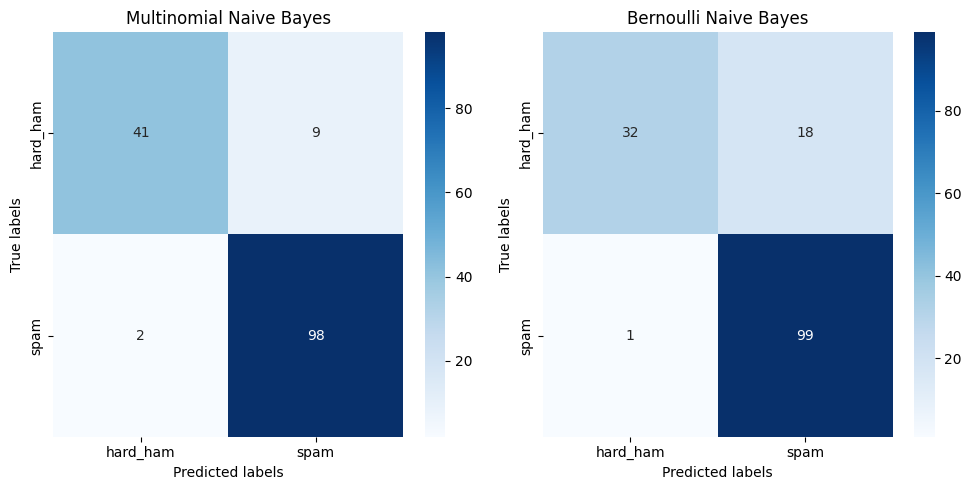

In [42]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, ax, labels):
    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

# Fit the vectorizer on the training data and transform the training and test data
vectorizer = CountVectorizer()
vectorizer.fit(hard_train['text'])
X_train = vectorizer.transform(hard_train['text'])
X_test = vectorizer.transform(hard_test['text'])
y_train = hard_train['label']
y_test = hard_test['label']

# Multinomial Naive Bayes
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred_mnb = model_mnb.predict(X_test)

# Bernoulli Naive Bayes
model_bnb = BernoulliNB()
model_bnb.fit(X_train, y_train)
y_pred_bnb = model_bnb.predict(X_test)

# Confusion matrices
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
cm_bnb = confusion_matrix(y_test, y_pred_bnb)

# Print classification reports
print("Multinomial Naive Bayes - Spam vs. Hard_Ham:")
print(classification_report(y_test, y_pred_mnb))
print('True positive rate (recall) for hard_ham: ' + str(cm_mnb[0][0] / (cm_mnb[0][0] + cm_mnb[0][1])))
print('False negative rate for hard_ham: ' + str(cm_mnb[0][1] / (cm_mnb[0][0] + cm_mnb[0][1])))
print('True positive rate (recall) for spam: ' + str(cm_mnb[1][1] / (cm_mnb[1][0] + cm_mnb[1][1])))
print('False negative rate for spam: ' + str(cm_mnb[1][0] / (cm_mnb[1][0] + cm_mnb[1][1])))

print("\n\nBernoulli Naive Bayes - Spam vs. Hard_Ham:")
print(classification_report(y_test, y_pred_bnb))
print('True positive rate (recall) for hard_ham: ' + str(cm_bnb[0][0] / (cm_bnb[0][0] + cm_bnb[0][1])))
print('False negative rate for hard_ham: ' + str(cm_bnb[0][1] / (cm_bnb[0][0] + cm_bnb[0][1])))
print('True positive rate (recall) for spam: ' + str(cm_bnb[1][1] / (cm_bnb[1][0] + cm_bnb[1][1])))
print('False negative rate for spam: ' + str(cm_bnb[1][0] / (cm_bnb[1][0] + cm_bnb[1][1])))

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_confusion_matrix(cm_mnb, axes[0], ['hard_ham', 'spam'])
axes[0].set_title('Multinomial Naive Bayes')

# Plot confusion matrix for Bernoulli Naive Bayes
plot_confusion_matrix(cm_bnb, axes[1], ['hard_ham', 'spam'])
axes[1].set_title('Bernoulli Naive Bayes')

plt.tight_layout()
plt.show()


# Comparision
On easy_ham in Q2, the Multinomial Naive Bayes performs better. We see this when the models are falsely predicting easy_ham when the true label is spam. In Q3, Multinomial Naive Bayes still performs better at true positives for correctly predicting ham data. However, with the hard_ham data in Q3, the model appears to be worse at classifying. But it is rather due to data imbalance where we have many spam-data points (spam biased data) instead of model failure.

### 4.	OPTIONAL - NOT MARKED:
To avoid classification based on common and uninformative words, it is common practice to filter these out.

**a.** Think about why this may be useful. Show a few examples of too common and too uncommon words.

**b.** Use the parameters in *scikit-learn*’s `CountVectorizer` to filter out these words. Update the program from Question 2 and run it on `easy-ham` vs `spam` and `hard-ham` vs `spam`. Report your results.

In [43]:
# @title
# a. Words common in both spam and ham emails will not help the model differentiate between the two classes.
#    Not including them will make the model focus on what is useful.

# b.
# Filter out words that appear in more than 90% of the documents
vectorizer = CountVectorizer(max_df=0.9) # max_df is the maximum ratio of documents a word is allowed to appear in
vectorizer.fit(easy_train['text'])
X_train = vectorizer.transform(easy_train['text'])
X_test = vectorizer.transform(easy_test['text'])
y_train = easy_train['label']
y_test = easy_test['label']

# Multinomial Naive Bayes
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred_mnb = model_mnb.predict(X_test)

# Bernoulli Naive Bayes
model_bnb = BernoulliNB()
model_bnb.fit(X_train, y_train)
y_pred_bnb = model_bnb.predict(X_test)

# Confusion matrices
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
cm_bnb = confusion_matrix(y_test, y_pred_bnb)

# Print classification reports
print("Multinomial Naive Bayes - Spam vs. Easy_Ham:")
print(classification_report(y_test, y_pred_mnb))
print('True positive rate (recall) for easy_ham: ' + str(cm_mnb[0][0] / (cm_mnb[0][0] + cm_mnb[0][1])))
print('False negative rate for easy_ham: ' + str(cm_mnb[0][1] / (cm_mnb[0][0] + cm_mnb[0][1])))
print('True positive rate (recall) for spam: ' + str(cm_mnb[1][1] / (cm_mnb[1][0] + cm_mnb[1][1])))
print('False negative rate for spam: ' + str(cm_mnb[1][0] / (cm_mnb[1][0] + cm_mnb[1][1])))

print("\n\nBernoulli Naive Bayes - Spam vs. Easy_Ham:")
print(classification_report(y_test, y_pred_bnb))
print('True positive rate (recall) for easy_ham: ' + str(cm_bnb[0][0] / (cm_bnb[0][0] + cm_bnb[0][1])))
print('False negative rate for easy_ham: ' + str(cm_bnb[0][1] / (cm_bnb[0][0] + cm_bnb[0][1])))
print('True positive rate (recall) for spam: ' + str(cm_bnb[1][1] / (cm_bnb[1][0] + cm_bnb[1][1])))
print('False negative rate for spam: ' + str(cm_bnb[1][0] / (cm_bnb[1][0] + cm_bnb[1][1])))

# Same but with hard_ham and spam
vectorizer = CountVectorizer(max_df=0.9)
vectorizer.fit(hard_train['text'])
X_train = vectorizer.transform(hard_train['text'])
X_test = vectorizer.transform(hard_test['text'])
y_train = hard_train['label']
y_test = hard_test['label']

# Multinomial Naive Bayes
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred_mnb = model_mnb.predict(X_test)

# Bernoulli Naive Bayes
model_bnb = BernoulliNB()
model_bnb.fit(X_train, y_train)
y_pred_bnb = model_bnb.predict(X_test)

# Confusion matrices
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
cm_bnb = confusion_matrix(y_test, y_pred_bnb)

# Print classification reports
print("Multinomial Naive Bayes - Spam vs. Hard_Ham:")
print(classification_report(y_test, y_pred_mnb))
print('True positive rate (recall) for hard_ham: ' + str(cm_mnb[0][0] / (cm_mnb[0][0] + cm_mnb[0][1])))
print('False negative rate for hard_ham: ' + str(cm_mnb[0][1] / (cm_mnb[0][0] + cm_mnb[0][1])))
print('True positive rate (recall) for spam: ' + str(cm_mnb[1][1] / (cm_mnb[1][0] + cm_mnb[1][1])))
print('False negative rate for spam: ' + str(cm_mnb[1][0] / (cm_mnb[1][0] + cm_mnb[1][1])))

print("\n\nBernoulli Naive Bayes - Spam vs. Hard_Ham:")
print(classification_report(y_test, y_pred_bnb))
print('True positive rate (recall) for hard_ham: ' + str(cm_bnb[0][0] / (cm_bnb[0][0] + cm_bnb[0][1])))
print('False negative rate for hard_ham: ' + str(cm_bnb[0][1] / (cm_bnb[0][0] + cm_bnb[0][1])))
print('True positive rate (recall) for spam: ' + str(cm_bnb[1][1] / (cm_bnb[1][0] + cm_bnb[1][1])))
print('False negative rate for spam: ' + str(cm_bnb[1][0] / (cm_bnb[1][0] + cm_bnb[1][1])))

Multinomial Naive Bayes - Spam vs. Easy_Ham:
              precision    recall  f1-score   support

    easy_ham       0.99      1.00      1.00       510
        spam       0.99      0.96      0.97       100

    accuracy                           0.99       610
   macro avg       0.99      0.98      0.98       610
weighted avg       0.99      0.99      0.99       610

True positive rate (recall) for easy_ham: 0.9980392156862745
False negative rate for easy_ham: 0.00196078431372549
True positive rate (recall) for spam: 0.96
False negative rate for spam: 0.04


Bernoulli Naive Bayes - Spam vs. Easy_Ham:
              precision    recall  f1-score   support

    easy_ham       0.92      1.00      0.95       510
        spam       0.96      0.54      0.69       100

    accuracy                           0.92       610
   macro avg       0.94      0.77      0.82       610
weighted avg       0.92      0.92      0.91       610

True positive rate (recall) for easy_ham: 0.996078431372549
Fal

### 5. OPTIONAL - NOT MARKED: Further improving performance
Filter out the headers and footers of the emails before you run on them. The format may vary somewhat between emails, which can make this a bit tricky, so perfect filtering is not required. Run your program again and answer the following questions:
- Does the result improve from those obtained in Questions 3 and 4?
- What do you expect would happen if your training set consisted mostly of spam messages, while your test set consisted mostly of ham messages, or vice versa?
- Look at the `fit_prior` parameter. What does this parameter mean? Discuss in what settings it can be helpful (you can also test your hypothesis).

In [ ]:
# write your code here